In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

image: (512, 512)   min: 0.0   max: 0.949019607843
kernel: (32, 32)   min: 0.0   max: 0.0627450980392


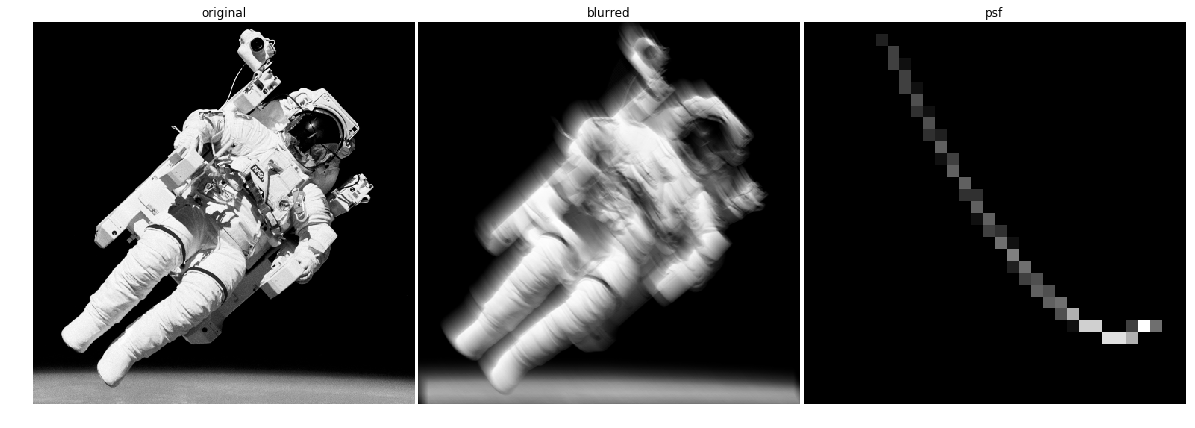

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from skimage import io, color
from scipy.signal import convolve2d as conv2
from skimage import color, data, restoration
from pprint import pprint

def showPics(pics, cols=2):
    plt.gray()
    plt.rcParams["figure.figsize"] = 16, 16
    plt.subplots_adjust(wspace=0.01, hspace=0.1, top=1, bottom=0, left=0, right=1)
    
    n= len(pics)
    rows= int((n+1)/cols)

    r= 1
    c= 1
    i= 1
    
    for pic in pics:
        if (c>cols):
            c= 0
            r+= 1
        
        plt.subplot(rows, cols, i)
        plt.imshow(pic[0])
        plt.title(pic[1])
        
        i+= 1
        c+= 1
        plt.axis('off')
 
    plt.show()    
    return


original= io.imread('scaled.png')
blurred= io.imread('blurred.png')/255
kernel= np.load("swirl.npy")

print ("image:" , blurred.shape , "  min:" , np.min(blurred), "  max:" , np.max(blurred))
print ("kernel:" , kernel.shape , "  min:" , np.min(kernel), "  max:" , np.max(kernel))

showPics([
    [original, "original"], 
    [blurred, "blurred"],
    [kernel, "psf"]],3)


240 256


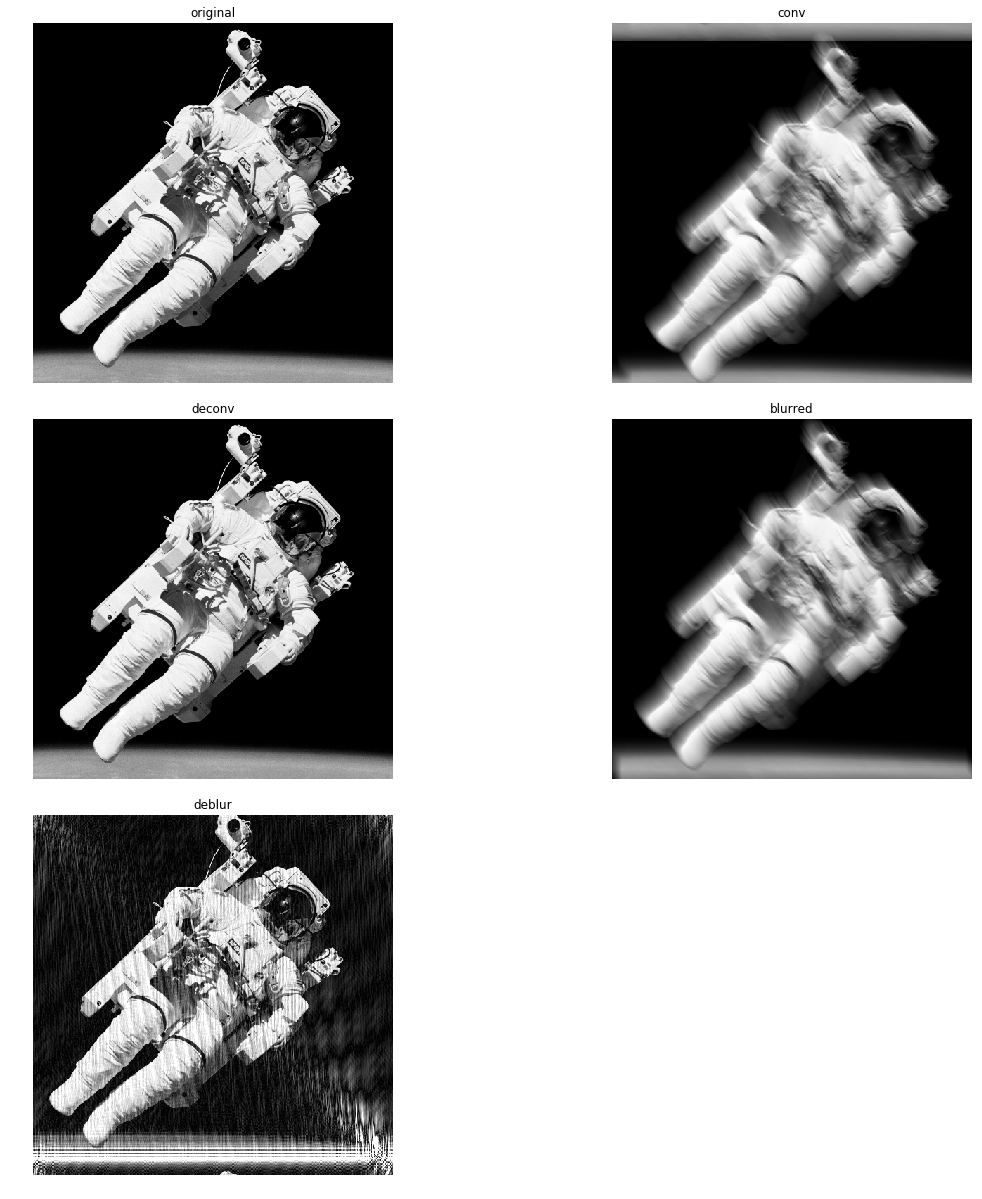

In [9]:
# https://cgcooke.github.io/Image-Deconvolution/

from scipy import mgrid,exp
import numpy as np
from numpy.fft import *
from PIL import Image

epsilon = 0.00001

def makeGaussianPSF(radius,sizeX,sizeY):
    """ Returns a normalized 2D gauss kernel array for convolutions """   
    x,y = mgrid[-sizeY/2:sizeY/2, -sizeX/2:sizeX/2]
    g = exp(-(x**2/float(radius)+y**2/float(radius)))
    return(g / g.sum())

def convolve(Input, psf, epsilon):
    InputFFT = fftn(Input)
    psfFFT = fftn(psf)+epsilon
    convolved = ifftn(InputFFT*psfFFT)
    convolved = np.abs(convolved)
    return(convolved)

def deconvolve(Input, psf, epsilon):
    InputFFT = fftn(Input)
    psfFFT = fftn(psf)+epsilon
    deconvolved = ifftn(InputFFT/psfFFT)
    deconvolved = np.abs(deconvolved)
    return(deconvolved)

def makeMotionPSF(length,sizeX,sizeY):
    psf = np.zeros((sizeY,sizeX))
    psf[sizeY/2:sizeY/2+1,sizeX/2-length/2:sizeX/2+length/2] = 1
    return(psf/psf.sum())

def upsize(arr, shape):
    res= np.zeros(shape)
    h,w= arr.shape
    
    r= int((shape[0] - h) /2)
    c= int((shape[1] - w) /2)

    res[r:r+h, c:c+w]= arr
        
    return res
    
def makeMotionPSF(length,sizeX,sizeY):
    psf = np.zeros((sizeY,sizeX))
    x=int(sizeX/2 - length/2)
    y=int(sizeY/2)
    print (x,y)
    psf[y:y+1,x: x + length ] = 1
    return(psf/psf.sum())    

def makeGaussianPSF(radius,sizeX,sizeY):
    """ Returns a normalized 2D gauss kernel array for convolutions """   
    x,y = mgrid[-sizeY/2:sizeY/2, -sizeX/2:sizeX/2]
    g = exp(-(x**2/float(radius)+y**2/float(radius)))
    return(g / g.sum())

def clip(img):
    return np.where(img > 1, 1, np.where(img < 0, 0, img)) 


psf= upsize(kernel, original.shape) 
psf= makeMotionPSF(32,512,512)
psf= np.zeros(original.shape)
psf[:32,:32]= kernel
 
####

conv = np.abs(convolve(original, psf, epsilon))
deconv = deconvolve(conv, psf, epsilon)
deblur = deconvolve(blurred, psf, epsilon)
deblur= clip(deblur)

####

#decon= deconvolve(blurred, psf, epsilon)

#decon = np.where(decon > 255, 255, decon) 
#decon = np.where(decon < 0, 0, decon)

showPics([ 
    [original, "original"],
    [conv, "conv"],
    [deconv, "deconv"],
    [blurred, "blurred"],
    [deblur, "deblur"]
    ])